In [10]:
import itertools
import os
import pickle
import random
from multiprocessing import Pool
from typing import Any, Callable, Dict, Iterable, Iterator, List, Optional, Tuple, Union

# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm

from replay_loading import enum_replay_folder, files_to_strokes, sample_stroke

%matplotlib inline
plt.style.use("ggplot")

In [2]:
replay_fns = list(itertools.islice(enum_replay_folder("H:/osu!/Data/r/"), 300))
strokes_subset = list(files_to_strokes(tqdm(replay_fns), min_length=50))
sum((len(s[0]) for s in strokes_subset))

100%|██████████| 300/300 [00:16<00:00, 17.94it/s]


1940603

In [3]:
# all_replays = list(enum_replay_folder("H:/osu!/Data/r/"))
# all_strokes = list(files_to_strokes(tqdm(all_replays), min_length=50))
# pickle.dump(all_strokes, open("all_strokes.pkl", "wb"))

In [4]:
all_strokes = pickle.load(open("all_strokes.pkl", "rb"))

In [5]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, transforms=None):
        self.strokes = strokes
        self.transforms = transforms
        self.wrand_sampler = WeightedRandomSampler([len(s[0]) for s in strokes], len(strokes), replacement=True)

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]
        
        # Apply the transformations if any
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
            return sample
        else:
            return sample[1]


class StrokeResample:
    def __init__(self, rate_range=(30, 250), max_length=2048):
        self.rate_range = rate_range
        self.max_length = max_length

    def __call__(self, sample):
        timings, positions = sample
        rate = np.random.uniform(*self.rate_range)
        offset = np.random.uniform(0, 1/rate)
        return sample_stroke(timings, positions, rate, offset, max_length=self.max_length)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class ScaleRotateFlip:
    def __init__(self, scale_range=(0.5, 1.5)):
        self.scale_range = scale_range

    def __call__(self, sample):
        scale = random.uniform(*self.scale_range)
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([
            [np.cos(angle), -flip * np.sin(angle)],
            [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


def collate_pad_beginning_zeroes(batch):
    max_len = max([len(stroke) for stroke in batch])
    padded_batch = [F.pad(stroke, (0, 0, max_len - len(stroke), 0)) for stroke in batch]
    return torch.stack(padded_batch)


transforms = [
    StrokeResample(max_length=4096),
    StrokeDiff(),
    ScaleRotateFlip(),
    StrokeToTensor(),
]

batch_size = 1024

ds_small = StrokeDataset(strokes_subset, transforms=transforms)
ds_small_loader = DataLoader(ds_small, batch_size=batch_size, sampler=ds_small.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

ds_full = StrokeDataset(all_strokes, transforms=transforms)
ds_full_loader = DataLoader(ds_full, batch_size=batch_size, sampler=ds_full.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

In [11]:
class TestNet3(nn.Module):
    def __init__(
        self, kernels=[5] * 12, channels=[8] * 4 + [4] * 4 + [2] * 4, dilations=[1] * 12
    ):
        super().__init__()

        self.kernels = torch.tensor(kernels + [1])
        self.channels = torch.tensor(channels + [2])
        self.in_channels = torch.tensor([2] + channels).cumsum(dim=0)[1:]
        self.dilations = torch.tensor(dilations + [1])
        self.pads = [
            (kernel - 1) * dilation
            for kernel, dilation in zip(self.kernels, self.dilations)
        ]
        self.pad_total = sum(self.pads)
        self.ar_len = None

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=self.in_channels[i],
                    out_channels=self.channels[i] * 2,
                    kernel_size=self.kernels[i],
                    dilation=self.dilations[i],
                )
                for i in range(len(self.kernels))
            ]
        )

    def forward(self, x):
        # input is (batch, seq_len, 2)
        x = x.mT  # (batch, 2, seq_len)
        seq_len = x.shape[-1]
        if self.ar_len is None:
            acts = torch.empty(
                len(self.convs) + 1, x.shape[0], 2, seq_len, device=x.device
            )
            acts[0] = x
            curr_window = x.shape[-1]
            for i, conv in enumerate(self.convs):
                x = acts[i, ..., -curr_window:]
                x = conv(x)
                x = F.glu(x, dim=1)
                curr_window -= self.pads[i]
                acts[i + 1, ..., -curr_window:] = x
            return acts[-1, ..., self.pad_total :].mT
        else:
            acts = torch.empty(
                len(self.convs) + 1,
                x.shape[0],
                2,
                seq_len + self.ar_len,
                device=x.device,
            )
            acts[0, ..., : -self.ar_len] = x[..., : -self.ar_len]
            # first pass
            curr_window = x.shape[-1]
            for i, conv in enumerate(self.convs):
                x = acts[i, ..., -curr_window : -self.ar_len]
                x = conv(x)
                x = F.glu(x, dim=1)
                curr_window -= self.pads[i]
                acts[i + 1, ..., -curr_window : -self.ar_len] = x
            # later autoregressive passes
            for ar_step in range(1, self.ar_len):
                acts[0, :, :2, ar_step - self.ar_len] = acts[
                    -1, :, :2, ar_step - self.ar_len - 1
                ]
                for i, conv in enumerate(self.convs):
                    x = acts[
                        i,
                        ...,
                        ar_step - self.ar_len - self.pads[i] : ar_step - self.ar_len,
                    ]
                    x = conv(x)
                    x = F.glu(x, dim=1)
                    acts[i + 1, ..., ar_step - self.ar_len] = x
            return acts[-1, ..., -self.ar_len :].mT


sum(p.numel() for p in TestNet3().parameters() if p.requires_grad)

15468

In [17]:
slice(2,4)

slice(2, 4, None)

In [43]:
torch.arange(12).reshape(3,4,1).mT.shape

torch.Size([3, 1, 4])

In [9]:
for i in torch.rand(5, 5):
    print(i)

tensor([0.1518, 0.7039, 0.9079, 0.4819, 0.7187])
tensor([0.1397, 0.2576, 0.0632, 0.7932, 0.5475])
tensor([0.0231, 0.4255, 0.3238, 0.5744, 0.6584])
tensor([0.5648, 0.4304, 0.2299, 0.6200, 0.9840])
tensor([0.2865, 0.1193, 0.1234, 0.4334, 0.6601])


In [192]:
smaller_params = {
    "kernels": [8, 6, 4, 3, 2],
    "channels": [2]*5
}

smaller_model = TestNet3(**smaller_params)

sum(p.numel() for p in smaller_model.parameters() if p.requires_grad), smaller_model.pad_total

(504, 18)

In [199]:
small_params = {
    "kernels": [5]*6,
    "channels": [2]*6,
    "dilations": [1, 2, 3, 4, 2, 1]
}

small_model = TestNet3(**small_params)

sum(p.numel() for p in small_model.parameters() if p.requires_grad), small_model.pad_total

(924, 52)

In [213]:
dilated2_params = {
    "kernels": [5]*7,
    "channels": [4, 4, 3, 3, 2, 2, 2],
    "dilations": [1, 2, 3, 4, 3, 2, 1]
}

dilated2_model = TestNet3(**dilated2_params)

sum(p.numel() for p in dilated2_model.parameters() if p.requires_grad), dilated2_model.pad_total

(2222, 64)

In [200]:
small_model.pads

[4, 8, 12, 16, 8, 4, 0]

In [214]:
# model = TestNet3().cuda()
# model = smaller_model.cuda()
# model = small_model.cuda()
model = dilated2_model.cuda()
unpad = model.pad_total + 1
optimizer = optim.AdamW(model.parameters(), lr=0.002)

losses = []
losses_verbose = []

Epoch 1, Loss: 0.5229712479735074, LR: 0.002
Epoch 2, Loss: 0.3821570545298868, LR: 0.0019782568627301367
Epoch 3, Loss: 0.3689375013521273, LR: 0.001913977730354388
Epoch 4, Loss: 0.36065788968513, LR: 0.0018099719094030729
Epoch 5, Loss: 0.35650813021616307, LR: 0.001670784953327064
Epoch 6, Loss: 0.3537160140466472, LR: 0.0015025000000000001
Epoch 7, Loss: 0.3478739497051936, LR: 0.001312471909403073
Epoch 8, Loss: 0.35018712132488755, LR: 0.0011090058209513155
Epoch 9, Loss: 0.34653664955265445, LR: 0.0009009941790486852
Epoch 10, Loss: 0.34713985821972154, LR: 0.0006975280905969276
Epoch 11, Loss: 0.3446148657091132, LR: 0.0005075000000000004
Epoch 12, Loss: 0.3462069177464263, LR: 0.0003392150466729365
Epoch 13, Loss: 0.3435532592202975, LR: 0.0002000280905969274
Epoch 14, Loss: 0.3437256664718123, LR: 9.602226964561204e-05
Epoch 15, Loss: 0.34169955517603384, LR: 3.174313726986335e-05


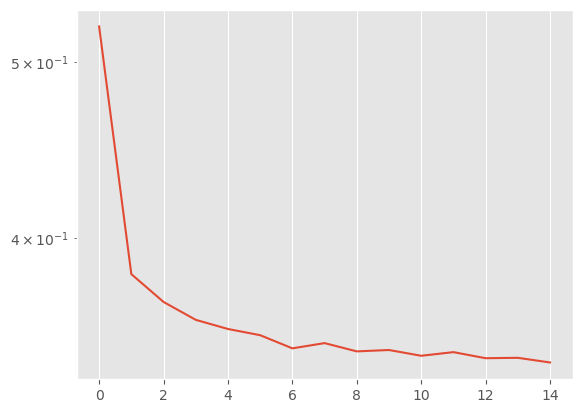

In [215]:
n_epochs = 15
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.00001)

for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch in ds_full_loader:
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.cuda()

        # Forward pass
        outputs = model(batch[:, :-1, :])

        # Compute loss
        loss = F.huber_loss(outputs, batch[:, unpad:, :])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    losses_verbose.append(epoch_losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, LR: {scheduler.get_last_lr()[0]}")

    # Update the learning rate
    scheduler.step()

plt.plot(losses)
plt.yscale('log')

In [216]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [219]:
model.cpu()
# torch.save(model.state_dict(), "model1.pth")

TestNet3(
  (convs): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(5,), stride=(1,))
    (1): Conv1d(6, 8, kernel_size=(5,), stride=(1,), dilation=(2,))
    (2): Conv1d(10, 6, kernel_size=(5,), stride=(1,), dilation=(3,))
    (3): Conv1d(13, 6, kernel_size=(5,), stride=(1,), dilation=(4,))
    (4): Conv1d(16, 4, kernel_size=(5,), stride=(1,), dilation=(3,))
    (5): Conv1d(18, 4, kernel_size=(5,), stride=(1,), dilation=(2,))
    (6): Conv1d(20, 4, kernel_size=(5,), stride=(1,))
    (7): Conv1d(22, 4, kernel_size=(1,), stride=(1,))
  )
)

In [223]:
torch.save(model.state_dict(), "dilated2_model.pth")

In [12]:
model = TestNet3()
model.load_state_dict(torch.load("model1.pth"))
model

TestNet3(
  (convs): ModuleList(
    (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,))
    (1): Conv1d(10, 16, kernel_size=(5,), stride=(1,))
    (2): Conv1d(18, 16, kernel_size=(5,), stride=(1,))
    (3): Conv1d(26, 16, kernel_size=(5,), stride=(1,))
    (4): Conv1d(34, 8, kernel_size=(5,), stride=(1,))
    (5): Conv1d(38, 8, kernel_size=(5,), stride=(1,))
    (6): Conv1d(42, 8, kernel_size=(5,), stride=(1,))
    (7): Conv1d(46, 8, kernel_size=(5,), stride=(1,))
    (8): Conv1d(50, 4, kernel_size=(5,), stride=(1,))
    (9): Conv1d(52, 4, kernel_size=(5,), stride=(1,))
    (10): Conv1d(54, 4, kernel_size=(5,), stride=(1,))
    (11): Conv1d(56, 4, kernel_size=(5,), stride=(1,))
    (12): Conv1d(58, 4, kernel_size=(1,), stride=(1,))
  )
)

In [13]:
model.pad_total

48

In [14]:
x = torch.zeros(1, model.pad_total + 1, 2)
x[:, -2, :] = torch.tensor([-0.05, 0.05])
x[:, -1, :] = torch.tensor([-0.1, 0.1])
model(x)

RuntimeError: The expanded size of the tensor (2) must match the existing size (8) at non-singleton dimension 1.  Target sizes: [1, 2, 45].  Tensor sizes: [8, 45]

In [35]:
model.cpu()
x = x.cpu()

In [221]:
%timeit model(x)

1.21 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [222]:
torch.onnx.export(model, x, "dilated2_model.onnx")

In [224]:
def autoregressive_call(x):
    res = x
    n = 5
    for i in range(n):
        res = torch.cat([res[:,1:,:], model(res)[:,-1:,:]], dim=1)
    return res[:, -n:, :]

In [226]:
torch.onnx.export(autoregressive_call, x, "dilated2_ar.onnx")

AttributeError: 'function' object has no attribute 'modules'

In [225]:
autoregressive_call(x)

tensor([[[-0.1185,  0.1132],
         [-0.1234,  0.1060],
         [-0.1334,  0.1007],
         [-0.1505,  0.1039],
         [-0.1711,  0.1115]]], grad_fn=<SliceBackward0>)

In [37]:
torch.export.export(model, (x,))

RuntimeError: Windows not yet supported for torch.compile

In [13]:
torch.onnx.export(model, x, "model1.onnx")#, verbose=True)

In [18]:
torch.onnx.export(model, torch.rand(4, 49, 2), "model2.onnx")

In [16]:
torch.onnx.dynamo_export(model, x, export_options=torch.onnx.ExportOptions(dynamic_shapes=True)).save("model3.onnx")

c:\Users\Abstract\mambaforge\envs\deepenv\Lib\site-packages\torch\onnx\_internal\exporter.py:137: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues